In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label

In [4]:
BASE_DIR = 'airbus-ship-detection'
TRAIN_DIR = BASE_DIR + '/train_v2/'
TEST_DIR = BASE_DIR + '/test_v2/'

In [5]:
masks = pd.read_csv(os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=2].head())

          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


Max of ships :  15
Avg of ships :  0.4244115997424126
Number of images with one ship:  27104


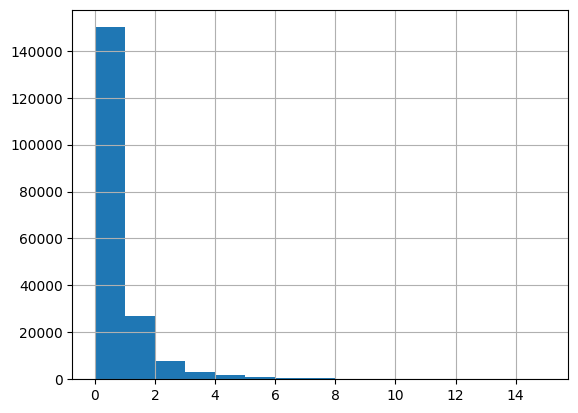

In [7]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())
print('Max of ships : ',unique_img_ids['ships'].max())
print('Avg of ships : ',unique_img_ids['ships'].mean())
print('Number of images with one ship: ', len(unique_img_ids[unique_img_ids['ships'] == 1]))

69660 masks


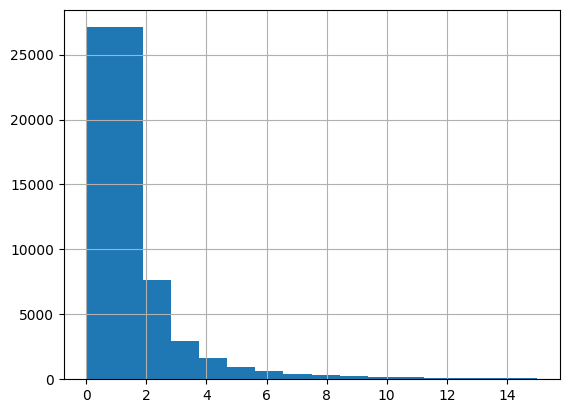

In [8]:
SAMPLES_PER_GROUP = 27104
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP \
                                                          else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
balanced_train_df

ImageId  ships  has_ship
ships                                       
0     25341   21c83c234.jpg      0       0.0
      160316  d547edd0b.jpg      0       0.0
      169169  e1001d0da.jpg      0       0.0
      189101  fb7b170a2.jpg      0       0.0
      50468   432ef4984.jpg      0       0.0
...                     ...    ...       ...
15    176401  ea9f82665.jpg     15       1.0
      179547  eec04e7a8.jpg     15       1.0
      186407  f7e6819bb.jpg     15       1.0
      190392  fd1de824c.jpg     15       1.0
      192184  ff7ac7f3c.jpg     15       1.0

[69660 rows x 3 columns]

In [10]:
import shutil

In [11]:
train_folder = './airbus-ship-detection/train'
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

In [12]:
src_folder = './airbus-ship-detection/train_v2'

for image_id in balanced_train_df['ImageId']:
    src_path = os.path.join(src_folder, image_id)
    dst_path = os.path.join(train_folder, image_id)
    shutil.copy(src_path, dst_path)